(52.3671947, 4.919245)
(52.3861999, 4.8811764)


C:\Users\Eigenaar\AppData\Local\Temp\ipykernel_26584\3982971718.py:14: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


(3781170134, 55.4897645320106) (305081090, 54.558073742088865)
Node found.
Node found.


C:\Users\Eigenaar\AppData\Local\Temp\ipykernel_26584\3982971718.py:37: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  length = sum(ox.utils_graph.get_route_edge_attributes(canals, path, 'length'))


[3781170134, 323929882, 331854233, 8010136114, 252142901, 324827507, 305155548, 305155547, 305156166, 8003741421, 9407684484, 324128505, 324126395, 1195429031, 730950175, 277138134, 178261171, 60740843, 117738457, 154546029, 305084168, 305082709, 305081090]
12
324126395
{'y': 52.3768364, 'x': 4.9027817, 'street_count': 3}
5004.24


C:\Users\Eigenaar\AppData\Local\Temp\ipykernel_26584\3982971718.py:63: UserWarning: The `get_route_edge_attributes` function has been deprecated and will be removed in a future release. Use the `route_to_gdf` function instead.
  lengths = ox.utils_graph.get_route_edge_attributes(canals, path, 'length')


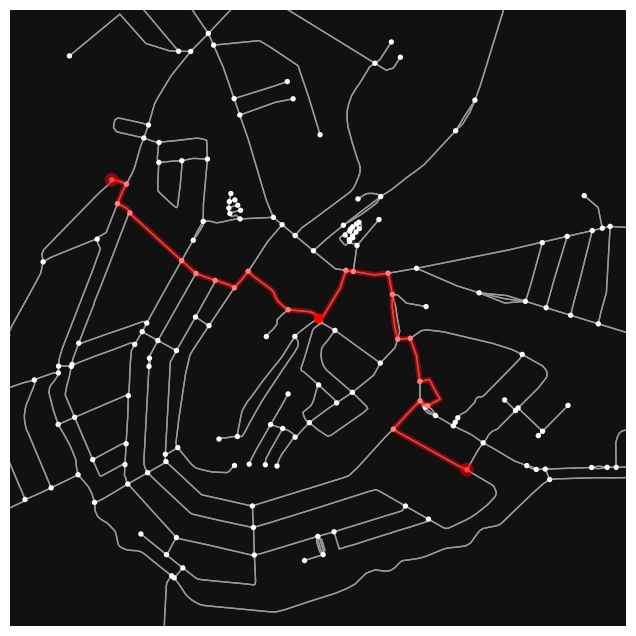

In [2]:
import osmnx as ox
import networkx as nx
import math
import warnings

#Hides annoying warnings :)
warnings.filterwarnings('ignore')

#Find coordinates of Artis (start point)
location_ARTIS = ox.geocode("Entrepotdok 86, Amsterdam, Netherlands")
print(location_ARTIS)

#Find coordinates of Westerpark (end point)
location_Westerpark = ox.geocode("Westerpark 1, Amsterdam, Netherlands")
print(location_Westerpark)

#This gets all the canal data from Amsterdam
ox.config(use_cache=True, log_console=True)
canals = ox.graph_from_place('Amsterdam, Netherlands', retain_all=False, truncate_by_edge=False,
                        simplify=True, custom_filter='["waterway"~"canal"]')


#Find the nearest nodes nearest node
nodes_ARTIS = ox.distance.nearest_nodes(canals, location_ARTIS[1], location_ARTIS[0], return_dist=True)
nodes_Westerpark = ox.distance.nearest_nodes(canals, location_Westerpark[1], location_Westerpark[0], return_dist=True)
print(nodes_ARTIS, nodes_Westerpark)

#Check if nodes exist
if nodes_ARTIS[0] in canals.nodes:
    print("Node found.")
if nodes_Westerpark[0] in canals.nodes:
    print("Node found.")

#This loop ensures a route is found between the start and end point of at least 5000m
L = 5000 #The route is 5000m long
path = ox.k_shortest_paths(canals, nodes_ARTIS[0], nodes_Westerpark[0], 1000, 'length')
for i, path in enumerate(path):
    length = sum(ox.utils_graph.get_route_edge_attributes(canals, path, 'length'))
    if length >= L:
        break
i, length, path

#These are the nodes of the path
print(path)

#Since the path is an odd list, this calculates the middle node
middle_node = math.ceil(len(path) / 2)
print(middle_node)
print(path[middle_node])

#Zoom in with middle point as center for bbox
node_middle = canals.nodes(data=True)[path[middle_node]]
print(node_middle)
bbox = ox.utils_geo.bbox_from_point((node_middle['y'], node_middle['x']), dist=2200)

#Plot graph of canals
pt = ox.graph_to_gdfs(canals, edges=False).unary_union.centroid
fig, ax = ox.plot_graph_route(canals, path, bbox=bbox, show=False, close=False)

#Plots the middle node of route
ax.scatter(canals.nodes[path[12]]['x'], canals.nodes[path[12]]['y'], c='red')

#This calculates the length of the path
lengths = ox.utils_graph.get_route_edge_attributes(canals, path, 'length')
path_length = sum(lengths)
print(path_length)



C:\Users\Eigenaar\AppData\Local\Temp\ipykernel_26584\126531336.py:2: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


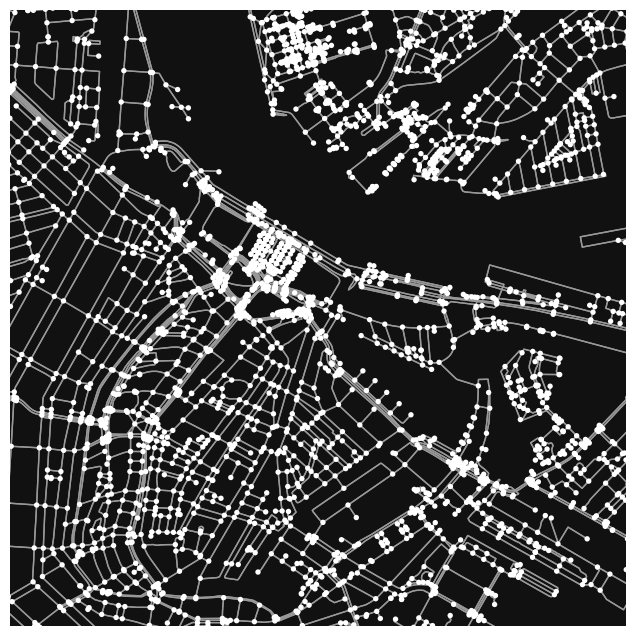

In [3]:
#This gets all the walkway data from Amsterdam
ox.config(use_cache=True, log_console=True)
walk = ox.graph_from_place('Amsterdam, Netherlands', network_type='walk')

#Plot graph of walkways
bbox = ox.utils_geo.bbox_from_point((node_middle['y'], node_middle['x']), dist=1200)
fig, ax = ox.plot_graph(walk, bbox=bbox, show=False, close=False)



In [4]:
#First we convert the coordinates of the start, middle and end point to nodes within the walk network
nodes_ARTIS_walk = ox.distance.nearest_nodes(walk, location_ARTIS[1], location_ARTIS[0], return_dist=True)
nodes_Westerpark_walk = ox.distance.nearest_nodes(walk, location_Westerpark[1], location_Westerpark[0], return_dist=True)
nodes_middle_walk = ox.distance.nearest_nodes(walk, node_middle['y'], node_middle['x'], return_dist=True)
print(nodes_ARTIS_walk, nodes_Westerpark_walk, nodes_middle_walk)

(1244055730, 21.449568174364654) (1332272245, 15.889468426704763) (10898968649, 6817815.1868821755)


In [5]:
#Use networkx to calculate the centrality
start_centrality = nx.closeness_centrality(walk, u=nodes_ARTIS_walk[0])
middle_centrality = nx.closeness_centrality(walk, u=nodes_middle_walk[0])
end_centrality = nx.closeness_centrality(walk, u=nodes_Westerpark_walk[0])

#Then we can print the centrality values
print('The centrality of the startpoint is', start_centrality)
print('The centrality of the startpoint is', middle_centrality)
print('The centrality of the startpoint is', end_centrality)

print(nodes_middle_walk[0])

The centrality of the startpoint is 0.01153460086131152
The centrality of the startpoint is 0.008907654888152539
The centrality of the startpoint is 0.011587075916593897
10898968649


In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
%matplotlib inline
ox.config(log_console=True)
ox.__version__

#set the variables to be used to find the area reachable in a certain amount of minutes by foot

trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

C:\Users\Eigenaar\AppData\Local\Temp\ipykernel_26584\2804774751.py:8: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(log_console=True)


In [7]:
#convert time to distance

meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in walk.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [8]:
#set color for isochrones
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

10898968649


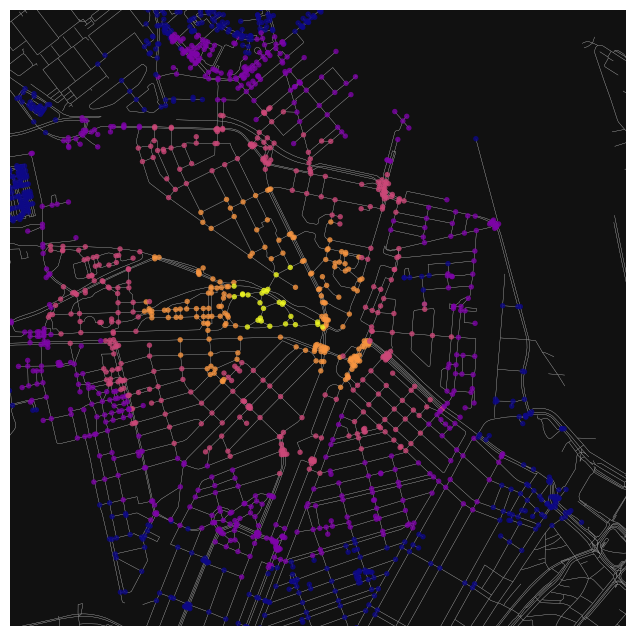

In [9]:
#assign colors to nodes

print(nodes_middle_walk[0])

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(walk, nodes_Westerpark_walk[0], radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in walk.nodes()]
ns = [15 if node in node_colors else 0 for node in walk.nodes()]

bbox = ox.utils_geo.bbox_from_point((location_Westerpark), dist=1200)


fig, ax = ox.plot_graph(walk, show=False, bbox = bbox, close=False, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

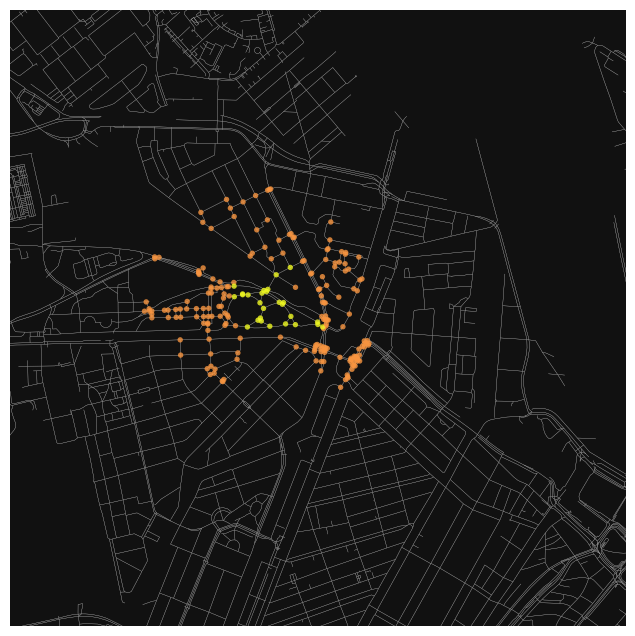

In [10]:
# Define trip times to be plotted
plot_trip_times = [5, 10]

# Create a dictionary to store node colors
node_colors = {}

# Assign colors to nodes for 5 and 10 minutes walking (the selected trip times)
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    if trip_time in plot_trip_times:
        subgraph = nx.ego_graph(walk, nodes_Westerpark_walk[0], radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color

# Create a list of node colors and sizes
nc = [node_colors.get(node, 'none') for node in walk.nodes()]
ns = [15 if node in node_colors else 0 for node in walk.nodes()]

# Define the bounding box based on the location
bbox = ox.utils_geo.bbox_from_point(location_Westerpark, dist=1200)

# Plot the graph of nodes reachable in 10 minutes
fig, ax = ox.plot_graph(walk, show=True, bbox=bbox, close=True, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')

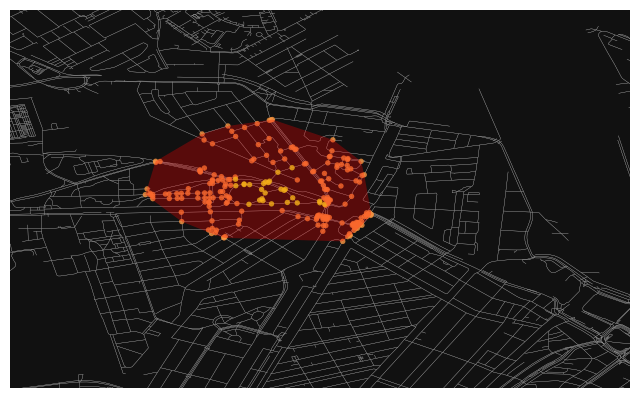

In [11]:
from shapely.geometry import MultiPoint

# Create a list of coordinates for the selected nodes
node_coordinates = [(data['x'], data['y']) for node, data in walk.nodes(data=True) if node in node_colors]

# Create a MultiPoint object and a convex hull
multi_point = MultiPoint(node_coordinates)
convex_hull = multi_point.convex_hull

# Plot the graph and the convex hull
fig, ax = ox.plot_graph(walk, show=False, bbox=bbox, close=False, node_color=nc, node_size=ns, node_alpha=0.8,
                        edge_linewidth=0.2, edge_color='#999999')
gpd.GeoSeries([convex_hull]).plot(ax=ax, color='red', alpha=0.3)
plt.show()

In [12]:
# Create a GeoDataFrame with the convex hull polygon as an extent
extent_gdf = gpd.GeoDataFrame(geometry=[convex_hull])

In [13]:
from shapely.ops import nearest_points

# Open OSM shapefile
gdf = gpd.read_file('Assignment 4\data')

# Select tram stops
gdf_tram_stops = gdf.loc[gdf['fclass'] == 'tram_stop']
gdf_bus_stops = gdf.loc[gdf['fclass'] == 'bus_stop']

# Start and finish point
target_point = Point(location_ARTIS[1], location_ARTIS[0])  
target_point_finish = Point(location_Westerpark[1], location_Westerpark[0])

#Set basics
nearest_point = None
min_distance = float('inf')

#Function to find the nearest stop from a certain target point
def find_nearest_stop(gdf_stops, target_point):
    min_distance = float('inf')
    nearest_stop = None

    for index, row in gdf_stops.iterrows():
        distance = row['geometry'].distance(target_point)
        if distance < min_distance:
            min_distance = distance
            nearest_stop = row
    return nearest_stop

# Find the nearest stops from the start point
nearest_tramfromstart = find_nearest_stop(gdf_tram_stops, target_point)
nearest_busfromstart = find_nearest_stop(gdf_bus_stops, target_point)

# Find the nearest stops from the finish point
nearest_busfromfinish = find_nearest_stop(gdf_bus_stops, target_point_finish)
nearest_tramfromfinish = find_nearest_stop(gdf_tram_stops, target_point_finish)

print(nearest_tramfromstart)
print(nearest_busfromstart)
print(nearest_busfromfinish)
print(nearest_tramfromfinish)


POINT (4.8811764 52.3861999)
<class 'pandas.core.series.Series'>
osm_id                      4623486305
code                              5621
fclass                        bus_stop
name                Wittenburgergracht
geometry    POINT (4.91969 52.3694102)
Name: 5262, dtype: object
osm_id                        4623486159
code                                5621
fclass                          bus_stop
name                         Nassauplein
geometry    POINT (4.8815551 52.3853766)
Name: 5255, dtype: object
osm_id                         46462976
code                               5603
fclass                        tram_stop
name                    Zoutkeetsgracht
geometry    POINT (4.8851416 52.388084)
Name: 21, dtype: object


In [14]:
import json
from shapely.geometry import mapping
import folium
map = folium.Map(location=(52.3768364, 4.9027817), zoom_start=14, control_scale=True)

#set GeoDataFrames to include all points
gdf_nearest_tram = gpd.GeoDataFrame(geometry=gpd.GeoSeries(nearest_tramfromstart['geometry']))
gdf_nearesttramfromfinish = gpd.GeoDataFrame(geometry=gpd.GeoSeries(nearest_tramfromfinish['geometry']))
gdf_nearest_bus = gpd.GeoDataFrame(geometry=gpd.GeoSeries(nearest_busfromstart['geometry']))
gdf_nearestbusfromfinish = gpd.GeoDataFrame(geometry=gpd.GeoSeries(nearest_busfromfinish['geometry']))
gdf_target_point = gpd.GeoDataFrame(geometry=gpd.GeoSeries(target_point))
gdf_target_point_finish = gpd.GeoDataFrame(geometry=gpd.GeoSeries(target_point_finish))

# Combine it into one GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    {'point_type': ['Tram stop near start', 'Tram stop near finish', 'Bus stop near start', 'Bus stop near finish', 'Start point', 'Finish point'],
     'geometry': [nearest_tramfromstart['geometry'], nearest_tramfromfinish['geometry'],  nearest_busfromstart['geometry'], nearest_busfromfinish['geometry'], target_point, target_point_finish]}
)

# Assign a color based on wheter a point is a tram stop, bus stop or start/finish point
gdf_points['color'] = gdf_points['point_type'].apply(lambda x: 'red' if 'Tram' in x else ('blue' if 'Bus' in x else 'green'))

# Add to map
gdf_points_json = json.loads(gdf_points.to_json())
folium.GeoJson(gdf_points_json, name='All Points').add_to(map)

# Assign marker for every point
for _, row in gdf_points.iterrows():
    popup_content = f"<strong>{row['point_type']}</strong><br>"
    folium.Marker(
        location=[row['geometry'].y, row['geometry'].x],
        popup=folium.Popup(popup_content, max_width=300),
        icon=folium.Icon(color=row['color'])
    ).add_to(map)
folium.LayerControl().add_to(map)
map

In [15]:
#Open shapefile containing data on restaurants and cafes and convert into two seperate GeoDataFrames

gdf_points_of_interest = gpd.read_file(r'C:\Users\Eigenaar\MADE - Data 1\Assignments\Assignment 4\data\gis_osm_pois_free_1.shp')
gdf_cafe = gdf_points_of_interest.loc[gdf_points_of_interest['fclass'] == 'cafe']
gdf_restaurant = gdf_points_of_interest.loc[gdf_points_of_interest['fclass'] == 'restaurant']

print(gdf_cafe)

            osm_id  code fclass                 name                  geometry
48        30250452  2303   cafe  Boerderij Meerzicht  POINT (4.82069 52.32627)
111       34032818  2303   cafe                Kiosk  POINT (4.87354 52.33921)
378      249442604  2303   cafe    Le Pain Quotidien  POINT (4.89124 52.35112)
416      251147180  2303   cafe                Stock  POINT (4.89565 52.37539)
449      251171043  2303   cafe   Coffeeshop Rock-it  POINT (4.89986 52.37286)
...            ...   ...    ...                  ...                       ...
52905  11237741524  2303   cafe           Good Beans  POINT (4.88726 52.38238)
52914  11237972779  2303   cafe              Margo's  POINT (4.88356 52.37776)
52972  11245180738  2303   cafe              Scratch  POINT (4.75070 52.37920)
53174  11262797203  2303   cafe           The Corner  POINT (4.95385 52.36832)
53175  11262915988  2303   cafe           Arket Café  POINT (4.88843 52.36699)

[1121 rows x 5 columns]


In [16]:
from shapely.geometry import box

#use the earlier created extent to clip the GeoDataFrames. Combine into one GeoDataFrame
clipped_gdf = gpd.overlay(gdf_points_of_interest, extent_gdf, how='intersection')
clipped_gdfextract = clipped_gdf[(clipped_gdf['fclass'] == 'restaurant') | (clipped_gdf['fclass'] == 'cafe')]

print(clipped_gdfextract)

         osm_id  code      fclass                name  \
6    1584693109  2303        cafe     Espressofabriek   
14   2189998308  2301  restaurant           Chez Nina   
17   2721298254  2301  restaurant  The Breakfast Club   
19   2788129031  2301  restaurant               Freud   
21   2788129779  2303        cafe         Cafe Walvis   
23   2788131374  2301  restaurant             Pinsa's   
26   2788284915  2303        cafe            Bar Mick   
32   2788448929  2301  restaurant         Bar Cocovin   
36   2788449246  2301  restaurant    Cantine de Caron   
37   2808992711  2303        cafe           Bar Braai   
60   4360884523  2303        cafe        Coffee Plaza   
63   4849512003  2303        cafe           Cafe Sage   
92  11084363975  2301  restaurant           de willem   
93  11220096975  2301  restaurant      Punjab Express   
94  11220098587  2301  restaurant                None   

                    geometry  
6   POINT (4.87192 52.38609)  
14  POINT (4.87484 52.384

C:\Users\Eigenaar\AppData\Local\Temp\ipykernel_26584\1327264084.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  clipped_gdf = gpd.overlay(gdf_points_of_interest, extent_gdf, how='intersection')


In [24]:
#Add all points with restaurants and cafes to map with bus and tram stops

for index, row in clipped_gdfextract.iterrows():
    popup_text = f"<strong>{row['name']}</strong><br>"
    folium.Marker(
        location=[row['geometry'].y, row['geometry'].x],
        popup=popup_text,
        icon=folium.Icon(color='purple'),  # Customize the marker icon as needed
    ).add_to(map)

map


In [ ]:
#References
'''
https://github.com/gboeing/osmnx-examples
https://wiki.openstreetmap.org/wiki/Key:highway
https://networkx.org/documentation/stable/reference/algorithms/centrality.html
https://osmnx.readthedocs.io/en/stable/user-reference.html#
https://bookdown.org/markhoff/social_network_analysis/centrality.html#closeness-centrality
https://stackoverflow.com/questions/49460880/adding-a-point-to-an-osmnx-plot
'''